In [1]:
# Generic imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os
from sys import platform
from importlib import reload
import sys
import scipy.optimize as optimization
sys.path.append('../../../../')
import plotly.graph_objects as go
from plotly.offline import iplot

# Local imports
import stlstuff as sls
import imagestuff as ims
import statstuff as sts
import retrievestuff as rs

CUDA not available.


The next cell has parameters that might change from crystal to crystal

In [2]:
# Loading in the compressed data
Segmentname = 'Segments1'
Flattenedfilename = Segmentname+'_compr_flat_filt.npz'; print(Flattenedfilename)

# Histogram accumulation: indexing starts at 0 for the upper-left, down, then across. Set to [] for all segments
accumlist = [] 

# Parameters for binning
Z2minforhist = 0.0
Z2maxforhist = .06
Z2offset = 0.001
nbins_max = 5
levels = 3

Segments1_compr_flat_filt.npz


In [3]:
# Derivative names
Roughnessfilename = Flattenedfilename[0:-4]+'_roughness.jpg'; print(Roughnessfilename)
flattenedfile = np.load(Flattenedfilename); print(Flattenedfilename)
xgridtot = flattenedfile['xgridtot']
ygridtot = flattenedfile['ygridtot']
zgridtot = flattenedfile['zgridtot']
nsegments = (len(xgridtot)); print(nsegments)

# This folder
cwd = os.getcwd(); i = cwd.index('crystals'); case_and_folder = cwd[i+9:]; print(case_and_folder)

Segments1_compr_flat_filt_roughness.jpg
Segments1_compr_flat_filt.npz
1
2023-07-27/90pa/case1.1 (roughness)


In [4]:
# Histogram accumulation
if len(accumlist)==0:
    accumlist = [i for i in range(nsegments)]
plotthisone = accumlist
print('Accumulating segments', accumlist)
print('Plotting segments', plotthisone)

# Parameters for binning
print('Z2 ranging from', Z2minforhist, 'to', Z2maxforhist)
print('Max number of bins specified is', nbins_max)
Ntot = np.size(zgridtot[0]) # Just using the first one for a size estimate
nbins_sturges = int(1+3.3*np.log10(Ntot)); print('Sturges rule says maxbins =', nbins_sturges)
nbins = np.min([nbins_max,nbins_sturges]); print('Using nbins = ', nbins)
Z2bins = np.linspace(Z2minforhist,Z2maxforhist,nbins); #print(Z2bins)
Z2theory = np.linspace(Z2minforhist,Z2maxforhist,50) 
# Z2theory=Z2theory[1:] 
Z2theory=Z2theory[:-1] + Z2offset
print('Using levels =', levels, 'for uncertainty analysis')

Accumulating segments [0]
Plotting segments [0]
Z2 ranging from 0.0 to 0.06
Max number of bins specified is 5
Sturges rule says maxbins = 11
Using nbins =  5
Using levels = 3 for uncertainty analysis


Original =  1920
4 0 480 [295 118  33  18]
4 1 480 [301 107  47  13]
4 2 480 [312 101  36  17]
4 3 480 [292 105  43  16]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.016499816033488688
statsigma =  0.12845160969598118

****Working on segment 0
std dev of height =  0.5074344710122772
integral =  0.00988673139158576
error =  [2.31704546 1.9084619  1.6781755  0.56674885]


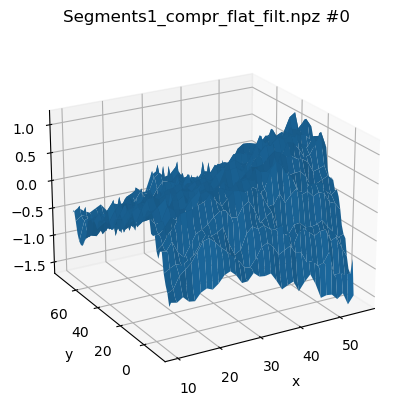

In [5]:
# Arrays for accumulating 
counts_list = []
meanZ2_list = []
Z2flat_list = []

# First-guess for Weibull fitting (sigma2W, etaW)
x0 = np.array([.1,.9])

# This suppresses warnings when lots of graphics windows are open
import matplotlib
matplotlib.rc('figure', max_open_warning = 0)

# This is for when we want to show or suppress intermediate graphics and other output
Show_intermediate_graphics = True

# Looping over segments
for isegment in range(nsegments):

    # Pull out the next segment
    sollast = zgridtot[isegment]
    xgrid = xgridtot[isegment] 
    ygrid = ygridtot[isegment]
    Ny, Nx = np.shape(sollast); #print(sollast.shape)
    Ntot = np.size(sollast)
    dx = xgrid[0,1]-xgrid[0,0]; #print('dx =', dx)
    dy = ygrid[1,0]-ygrid[0,0]; #print('dy =', dy)

    # Get the probability distribution in Z2
    counts, bins, meanZ2, Z2flat, error = rs.getrhoofz2(sollast,dx,dy,Z2bins=Z2bins,levels=levels)
    print('meanZ2 = ', meanZ2)
    print('statsigma = ', np.sqrt(meanZ2))

    # Plot if we want
    if isegment in plotthisone:
        
        # Reporting
        print('')
        print('****Working on segment', isegment)
        
        # Graph the surface
        if Show_intermediate_graphics:
            fig1 = plt.figure()
            ax = fig1.add_subplot(111, projection='3d')
            ax.plot_surface(xgrid, ygrid, sollast)
            title = Flattenedfilename+' #'+str(isegment)
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')
            ax.set_title(title)
            ax.view_init(azim=-120,elev=22)
        
        # Normalize the distribution function, report stats
        integral_rho = np.trapz(counts, bins)
        print ('std dev of height = ', np.std(sollast))
        print('integral = ', integral_rho)
        counts = counts/integral_rho
        error = error/integral_rho
        print('error = ', error)

#         # This is for calculating the errors in fitting (and graphing)
#         countsplus = counts+error; #print(countsplus)
#         countsminus = counts**2/countsplus; #print(countsminus)

#         # Graph the probability
#         if Show_intermediate_graphics:
            
#             # Using plotly
#             plot1 = go.Scatter(x=bins, y=np.log(counts), marker=dict(color='blue'),mode='markers')
#             plot2 = go.Scatter(x=bins, y=np.log(countsplus), marker=dict(color='black'),mode='markers')
#             plot3 = go.Scatter(x=bins, y=np.log(countsminus), marker=dict(color='black'),mode='markers')
#             iplot([plot1,plot2,plot3])

#         # Eliminate entries greater than a threshold (not sure if this is necessary)
#         ikeep = np.argwhere(Z2flat < Z2maxforhist)
#         Z2flat_new = np.squeeze(Z2flat[ikeep])

#         # Specify errors in a log space
#         errors = countsplus/counts; #print(errors)
        
#         # Do a linear fit
#         f_linear = lambda x, a, b: a + b*x   # function to fit
#         solution, corr = optimization.curve_fit(f_linear, bins+Z2offset, np.log(counts), [5, -100], errors)
#         a_linear_optimized = solution[0]; print('a_linear_optimized', a_linear_optimized)
#         b_linear_optimized = solution[1]; print('b_linear_optimized', b_linear_optimized)
#         sigma2G = -1/b_linear_optimized
#         sigmaG = np.sqrt(sigma2G); print('sigmaG', sigmaG)

#         # Do a quadratic fit
#         f_quadratic = lambda x, a, b, c: a + b*x +c*x**2  # function to fit
#         solution, corr = optimization.curve_fit(f_quadratic, bins+Z2offset, np.log(counts), [5, -100, 0], errors)
#         a_quadratic_optimized = solution[0]; print('a_quadratic_optimized', a_quadratic_optimized)
#         b_quadratic_optimized = solution[1]; print('b_quadratic_optimized', b_quadratic_optimized)
#         c_quadratic_optimized = solution[2]; print('c_quadratic_optimized', c_quadratic_optimized)
#         sigma2W = -1/b_quadratic_optimized
#         sigmaW = np.sqrt(sigma2W); print('approximate sigmaW', sigmaW)
        
#         # Calculate the Gaussian fit
#         myGaussian = sts.Gaussian(Z2theory,sigma2G)
        
#         # Calculate the Weibill fit -- 
#         # Note that this is a kluge: it should be replaced by myWeibull = sts.Weibull(Z2theory,sigma2W,etaW)
#         myWeibull = np.exp(f_quadratic(Z2theory,a_quadratic_optimized,b_quadratic_optimized,c_quadratic_optimized))

#         # Graph data with the best-fit probabilities
#         if Show_intermediate_graphics:
#             # Using matplotlib
#             plt.figure()
#             plt.semilogy(bins, counts, 'ok')
#             plt.semilogy(bins, countsplus, '+k')
#             plt.semilogy(bins, countsminus,'+k')
#             plt.title(title)
#             plt.xlabel(r'$Z^{2}$')
#             plt.ylabel(r'$\rho$')
#             plt.grid(True)
#             plt.semilogy(Z2theory, myGaussian, 'b',label = 'Gaussian with $\sigma_G$ = ' + str(sigmaG)[0:5])
#             plt.semilogy(Z2theory, myWeibull, 'g--',label = 'Quadratic')
#             plt.legend()

    # Accumulate if we want
    if isegment in accumlist:
        counts_list.append(counts)
        meanZ2_list.append(meanZ2)
        Z2flat_list.append(Z2flat)

In [6]:
# Sum up the accumulated information
Z2flat_total = []
for i in Z2flat_list:
    for j in i:
        Z2flat_total.append(j)
Z2flat_total = np.array(Z2flat_total)
Z2flat_new = np.squeeze(Z2flat_total)

# Get the probability distribution in Z2
counts, bins, meanZ2, error = rs.getrhoofz2flat(Z2flat,nbins,Z2bins,levels)
print('meanZ2 = ', meanZ2)
print('statsigma = ', np.sqrt(meanZ2))

# Normalize the distribution function
integral_rho = np.trapz(counts, bins)
print('integral = ', integral_rho)
counts = counts/integral_rho
error = error/integral_rho
countsplus = counts+error; #print(countsplus)
countsminus = counts**2/countsplus; #print(countsminus)

Original =  1920
4 0 480 [295 118  33  18]
4 1 480 [301 107  47  13]
4 2 480 [312 101  36  17]
4 3 480 [292 105  43  16]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.016499816033488688
statsigma =  0.12845160969598118
integral =  0.00988673139158576


a_linear_optimized 4.224399648560899
b_linear_optimized -65.35389948822117
sigmaG 0.12369844695967189
a_quadratic_optimized 4.2550145187006505
b_quadratic_optimized -71.08649850082915
c_quadratic_optimized 123.88474213228271
sigmaQ 0.11860593967012545
sigmaW 0.12179645225659326


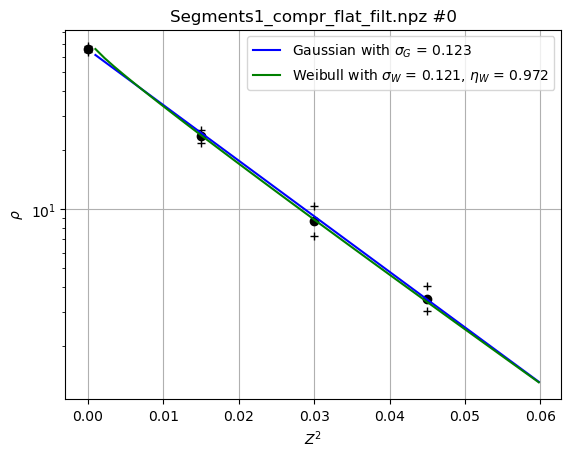

In [7]:
# Specify errors in a log space
errors = countsplus/counts; #print(errors)

# Do a linear fit
f_linear = lambda x, a, b: a + b*x   # function to fit
solution, corr = optimization.curve_fit(f_linear, bins+Z2offset, np.log(counts), [5, -100], errors)
a_linear_optimized = solution[0]; print('a_linear_optimized', a_linear_optimized)
b_linear_optimized = solution[1]; print('b_linear_optimized', b_linear_optimized)

# Calculate the Gaussian parameter (sigmaG) from the best-fit slope, and the resulting PDF
sigma2G = -1/b_linear_optimized
sigmaG = np.sqrt(sigma2G); print('sigmaG', sigmaG)
myGaussian = sts.Gaussian(Z2theory,sigma2G)

# Do a quadratic fit
f_quadratic = lambda x, a, b, c: a + b*x +c*x**2  # function to fit
solution, corr = optimization.curve_fit(f_quadratic, bins+Z2offset, np.log(counts), [5, -100, 0], errors)
a_quadratic_optimized = solution[0]; print('a_quadratic_optimized', a_quadratic_optimized)
b_quadratic_optimized = solution[1]; print('b_quadratic_optimized', b_quadratic_optimized)
c_quadratic_optimized = solution[2]; print('c_quadratic_optimized', c_quadratic_optimized)

# Calculate Quadratic parameters (sigmaQ, etaQ) from the best-fit slope and curvature, and the resulting PDF
sigma2Q, etaQ = sts.bc_to_Q_parameters(b_quadratic_optimized,c_quadratic_optimized)
sigmaQ = sigma2Q**.5; print('sigmaQ', sigmaQ)
myQuadratic = sts.Quadratic(Z2theory,sigma2Q,etaQ)
myQuadratic *= counts[0]/myQuadratic[0] # This is a kluge until we get the normalization factor formula

# Calculate Weibull parameters (sigmaW, etaW) from the best-fit slope and curvature, and the resulting PDF
sigma2W, etaW = sts.bc_to_Weibull_parameters(b_quadratic_optimized,c_quadratic_optimized)
sigmaW = sigma2W**.5; print('sigmaW', sigmaW)
myWeibull = sts.Weibull(Z2theory,sigma2W,etaW)

# Graph data with the best-fit probabilities
plt.figure()
plt.semilogy(bins, counts, 'ok')
plt.semilogy(bins, countsplus, '+k')
plt.semilogy(bins, countsminus,'+k')
plt.title(title)
plt.xlabel(r'$Z^{2}$')
plt.ylabel(r'$\rho$')
plt.grid(True)
plt.semilogy(Z2theory, myGaussian, 'b',label = 'Gaussian with $\sigma_G$ = ' + str(sigmaG)[0:5])
plt.semilogy(Z2theory, myWeibull, 'g',label = \
             'Weibull with $\sigma_W$ = ' + str(sigmaW)[0:5] + ', $\eta_W$ = ' + str(etaW)[0:5])
# plt.semilogy(Z2theory, myQuadratic, 'r--',label = \
#              'Quadratic with $\sigma_Q$ = ' + str(sigmaQ)[0:5] + ', $\eta_Q$ = ' + str(etaQ)[0:5])
plt.legend()

In [8]:
# # Save the roughness figure
# plt.savefig(Roughnessfilename)

In [9]:
# Saving ith segment as a textfile.
saving_text_file = False
if saving_text_file:
    iSegment = 0
    zfilename = Segmentname+'_z_values.csv'; print(zfilename)
    xfilename = Segmentname+'_x_values.csv'; print(xfilename)
    yfilename = Segmentname+'_y_values.csv'; print(yfilename)
    Z2filename = Segmentname+'_Z2_values.csv'; print(Z2filename)
    print(np.shape(zgridtot))
    print(np.shape(Z2flat_list[iSegment]))

    myxgridtot = xgridtot[iSegment,0,:]
    myygridtot = ygridtot[iSegment,:,0]
    myzgridtot = zgridtot[iSegment,:,:]
    myZ2flat = Z2flat_list[iSegment]

    nxy = np.shape(myzgridtot)
    ny = nxy[0]
    nx = nxy[1]
    print(nxy)

    myZ2 = np.reshape(myZ2flat, (ny-1,nx-1)) # Z2 is 1 shorter in either dimension

    print(np.shape(myZ2))
    np.savetxt(zfilename, myzgridtot, delimiter = ',')
    np.savetxt(xfilename, myxgridtot, delimiter = ',')
    np.savetxt(yfilename, myygridtot, delimiter = ',')
    np.savetxt(Z2filename, Z2flat_list[iSegment], delimiter = ',')

    fig = go.Figure(data = go.Surface(x = myxgridtot[1:], y = myygridtot[1:], z = myZ2))
    fig.update_layout(scene = dict(xaxis_title = 'x',yaxis_title = 'y',zaxis_title = 'z'))